In [10]:
import numpy as np
import pandas as pd
import plotnine as pn
from rdot import ba_basic, ba_ib, ba_basic, ba_ib
from rdot import distortions

### Hamming

In [11]:
x = np.array([0,1]) # Binary input
xhat = np.array([0,1]) # Binary reconstruction
p = 0.5 # P(X=1) = p
px = np.array([1-p, p])

# distortion matrix
dist_mat = distortions.hamming(*np.meshgrid(x, xhat))        

# Test many values of beta to sweep out a curve. 
betas = np.logspace(-5, 5, num=100)        

rd_values = [result[-2:] for result in ba_basic.ba_iterate(px, dist_mat, betas)]

In [12]:
rd_values[20]

(1.9791947636349505e-07, 0.49973809608575587)

In [13]:
data = pd.DataFrame(rd_values, columns=["rate", "distortion"])
# data

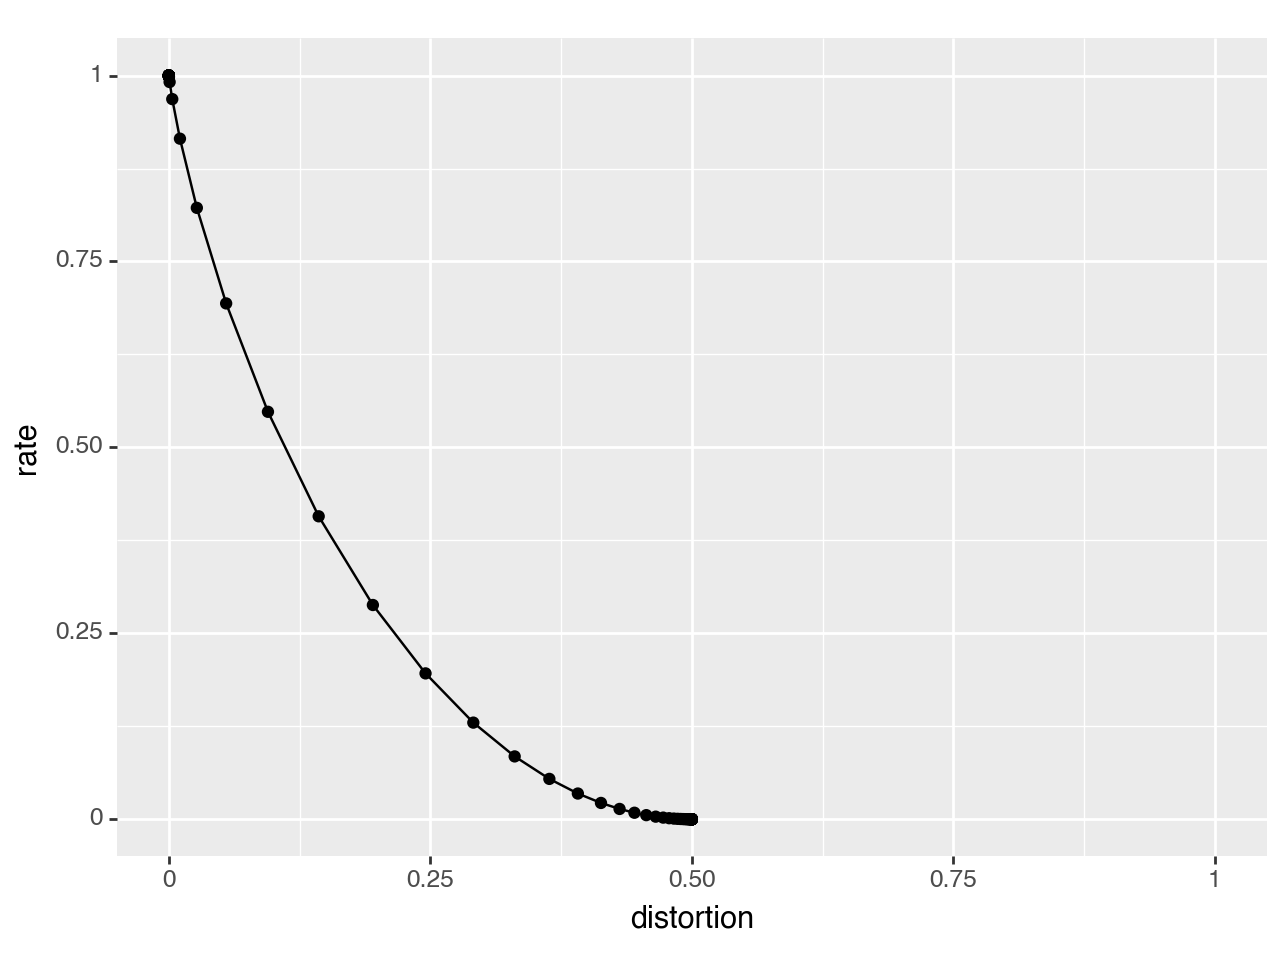

<Figure Size: (640 x 480)>

In [14]:
# Compare to figure 10.4 of Cover and Thomas
(
    pn.ggplot(data, pn.aes(x="distortion", y="rate"))
    + pn.geom_point()
    + pn.geom_line()
    + pn.xlim(0,1)
)

### Gaussian

In [15]:
# (truncated) Gaussian input with quadratic distortion
x = np.linspace(-5,5,1000) # source alphabet
xhat = np.linspace(-5,5,1000) # reconstruction alphabet
px = 1/(2*np.pi) * np.exp(-x ** 2 / 2) # source pdf
px /= px.sum() # guess we actually need this

dist_mat = distortions.quadratic(x, xhat)


# Test many values of beta to sweep out a curve. 
betas = np.logspace(-5, 10, num=100)        

rd_values = [result[-2:] for result in ba_basic.ba_iterate(px, dist_mat, betas)]

In [16]:
data = pd.DataFrame(rd_values, columns=["rate", "distortion"])
# data

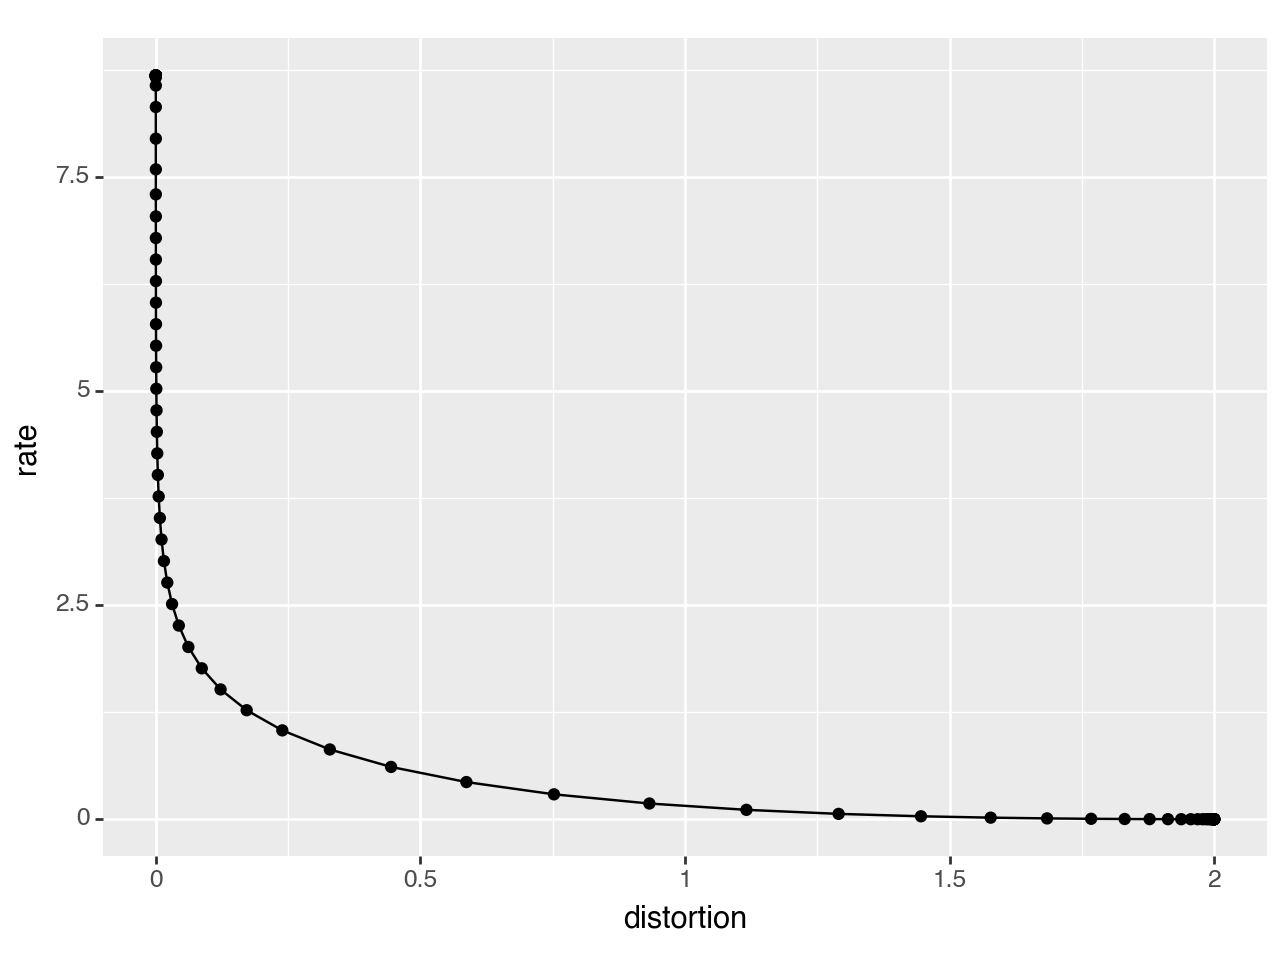

<Figure Size: (640 x 480)>

In [17]:
# Compare to figure 10.4 of Cover and Thomas
(
    pn.ggplot(data, pn.aes(x="distortion", y="rate"))
    + pn.geom_point()
    + pn.geom_line()
)

## IB

In [29]:
# define each p(y|x) to be a gaussian
py_x = np.array([[np.exp(-(i - j)**2) for j in range(10)] for i in range(10)])
py_x /= py_x.sum(axis=1)[:, None]
# get joint by multiplying by p(x)
px = np.full(py_x.shape[0], 1/10)
pxy = py_x * px

# Test many values of beta to sweep out a curve. 
betas = np.logspace(-2, 5, num=100)

rd_values = [
    result[-3:] for result in ba_ib.ib_method(
        pxy, 
        betas,
        num_restarts=1,
    )
]


100%|██████████| 100/100 [00:05<00:00, 17.03it/s]


In [30]:
data = pd.DataFrame(
    rd_values, 
    columns=[
        "rate", 
        "distortion",
        "accuracy",
    ]
)
# data

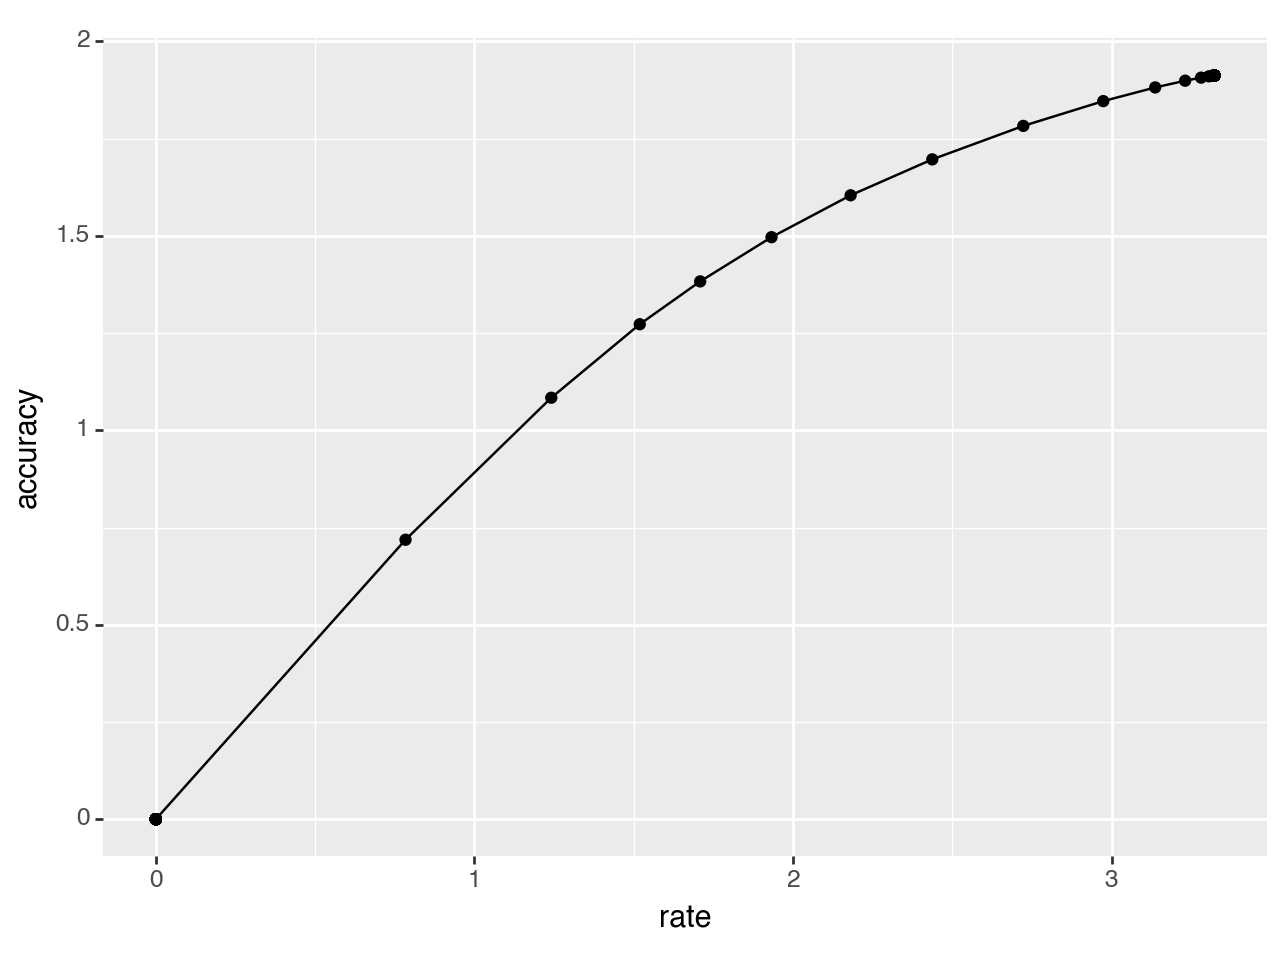

<Figure Size: (640 x 480)>

In [31]:
(
    pn.ggplot(data, pn.aes(x="rate", y="accuracy"))
    + pn.geom_point()
    + pn.geom_line()
)

## Embo validation

In [32]:
from embo import InformationBottleneck

In [33]:
result = InformationBottleneck(
    pxy=pxy,
).get_bottleneck()

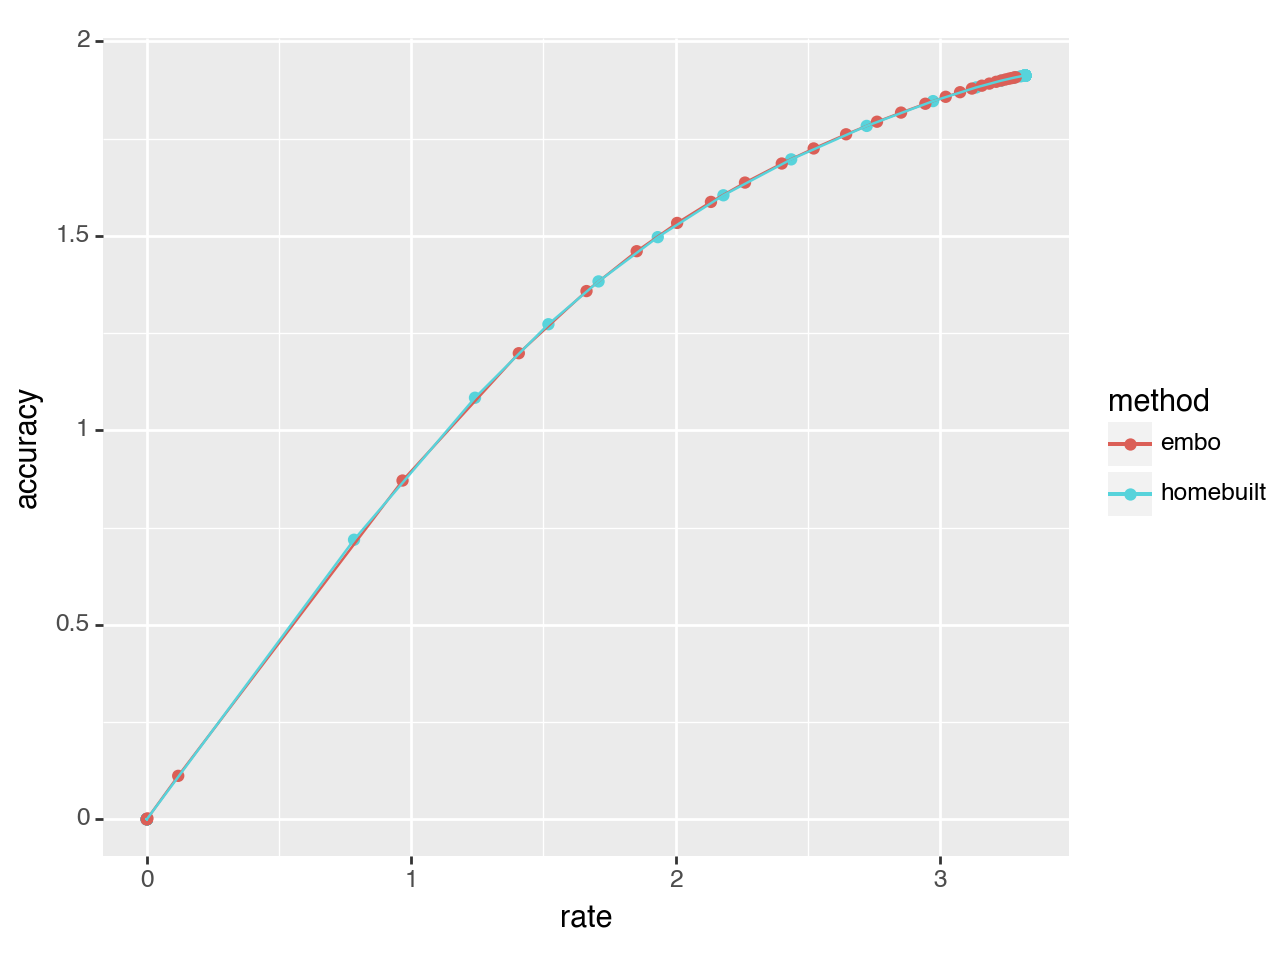

<Figure Size: (640 x 480)>

In [34]:
data["method"] = "homebuilt"
data_embo = pd.DataFrame(zip(*result[0:2]), columns=["rate", "accuracy"])
data_embo["method"] = "embo"
data = pd.concat([data, data_embo])
(
    pn.ggplot(data, pn.aes(x="rate", y="accuracy", color="method"))
    + pn.geom_point()
    + pn.geom_line()    
)

Additional distribution testing

In [35]:
# As noga suggested
py_x = np.array(
    [[0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1], 
     [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]]
).T
py_x /= py_x.sum(axis=1)[:, None]
# get joint by multiplying by p(x)
px = np.full(py_x.shape[0], 1/9)
pxy = py_x * px[:,None]

# Test many values of beta to sweep out a curve. 
betas = np.logspace(-2, 5, num=100)
# betas = np.linspace(1e-5, 5, num=100)

rd_values = [
    result[-3:] for result in ba_ib.ib_method(
        pxy, 
        betas,
        num_restarts=1,
    )
]


100%|██████████| 100/100 [00:00<00:00, 103.51it/s]


In [36]:
data = pd.DataFrame(
    rd_values, 
    columns=[
        "rate", 
        "distortion",
        "accuracy",
    ]
)
# data

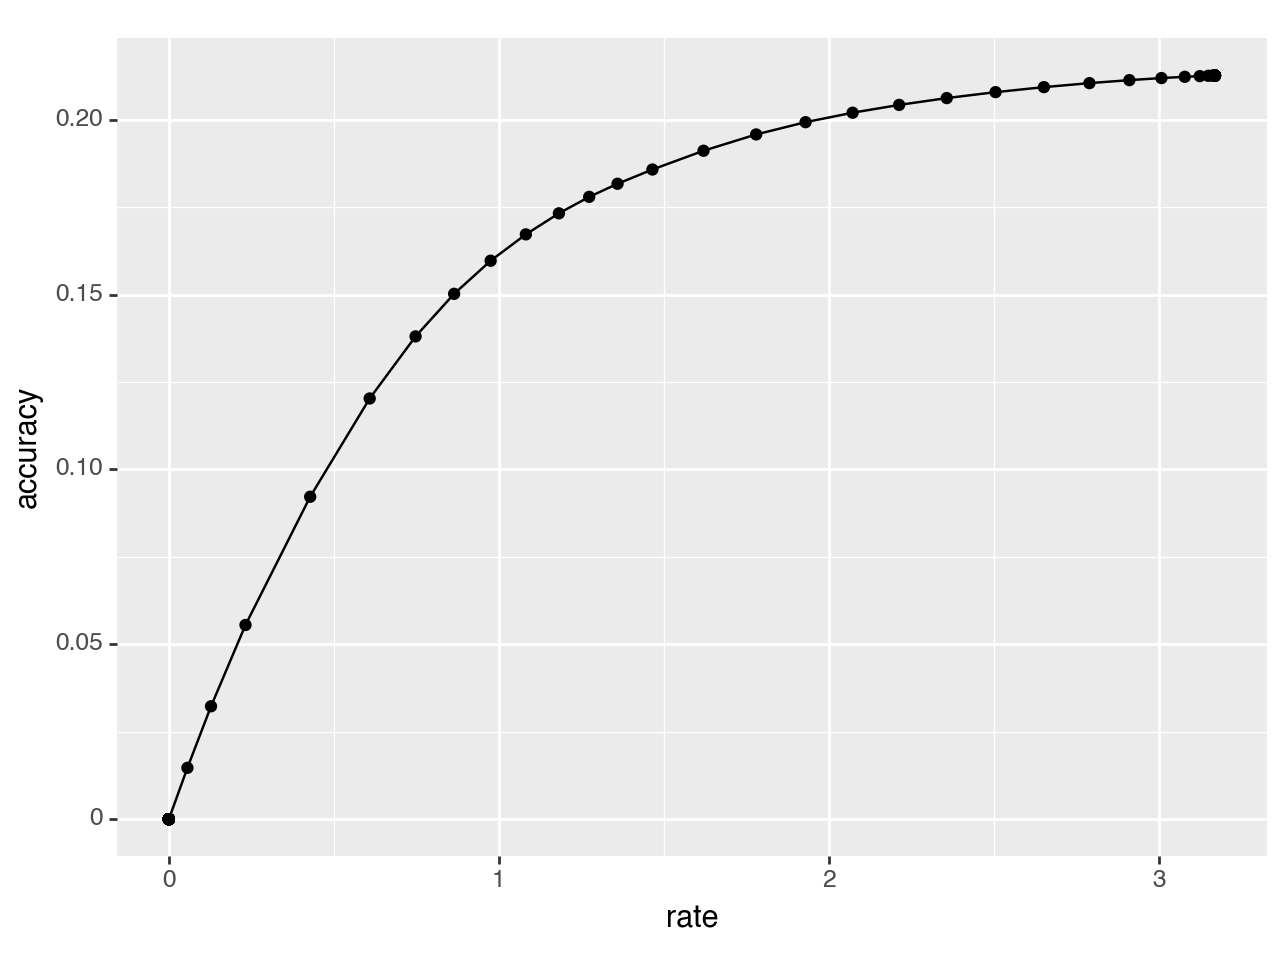

<Figure Size: (640 x 480)>

In [37]:
(
    pn.ggplot(data, pn.aes(x="rate", y="accuracy"))
    + pn.geom_point()
    + pn.geom_line()
)

In [38]:
result = InformationBottleneck(
    pxy=pxy,
).get_bottleneck()

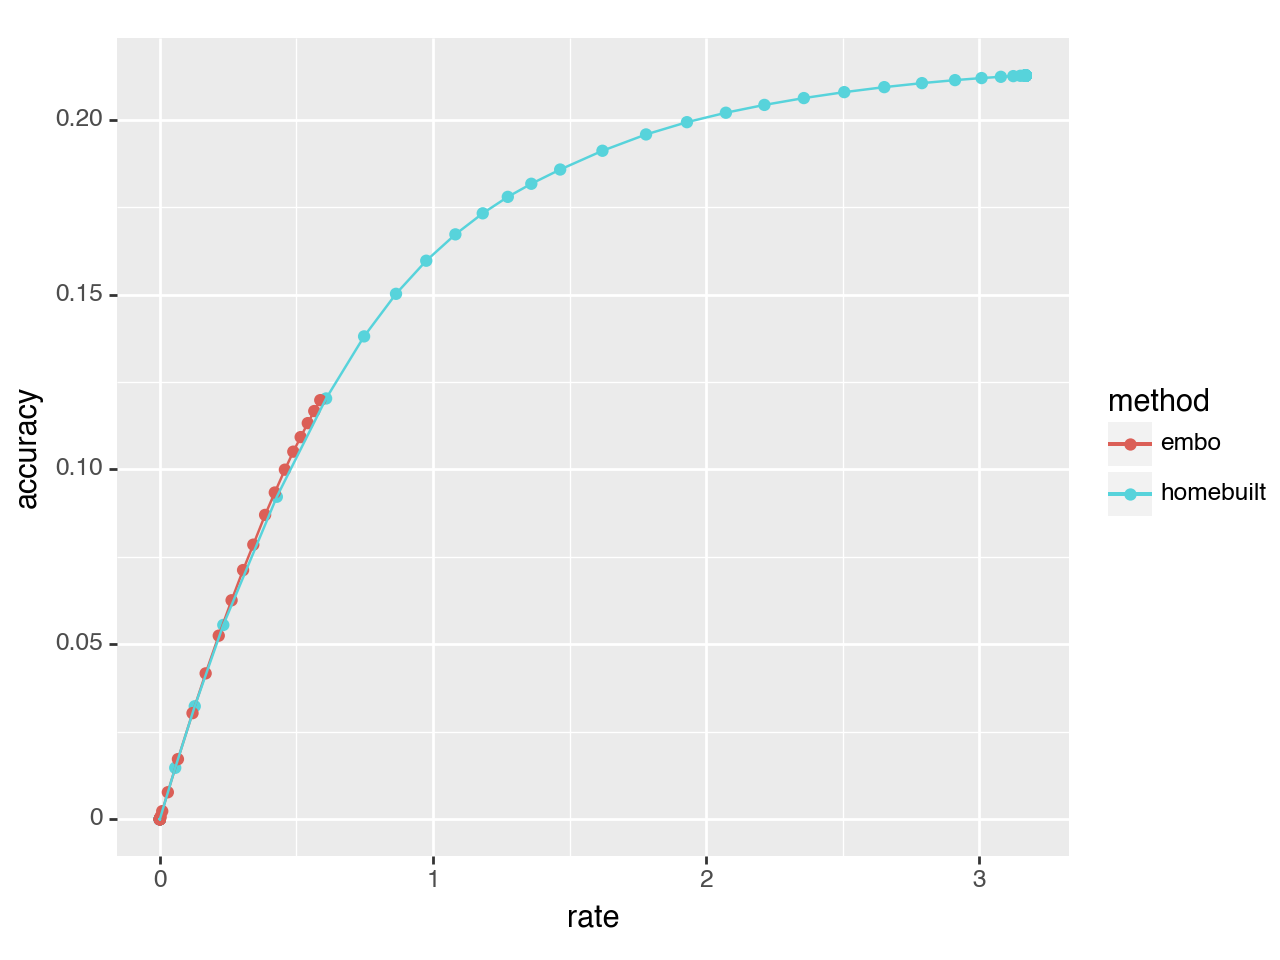

<Figure Size: (640 x 480)>

In [39]:
data["method"] = "homebuilt"
data_embo = pd.DataFrame(zip(*result[0:2]), columns=["rate", "accuracy"])
data_embo["method"] = "embo"
data = pd.concat([data, data_embo])
(
    pn.ggplot(data, pn.aes(x="rate", y="accuracy", color="method"))
    + pn.geom_point()
    + pn.geom_line()    
)